<a href="https://colab.research.google.com/github/julianaquin/energy-consumption-ML/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Project**


### **The context**

> Climate change is an urgent, relevant and mul3-dimensional global issue with a significant impact on energy policy and infrastructure. Tackling climate change involves both mi3ga3on (i.e. reducing greenhouse gas emissions) and adapta3on (i.e. preparing for the inevitable consequences). Mi3ga3ng greenhouse gas emissions requires changes to electricity systems, transport, buildings, industry and land use.
According to a report published by the Interna3onal Energy Agency (IEA), the life cycle of buildings, from construc3on to demoli3on, is responsible for 37% of global CO2 emissions linked to energy and processes in 2020. Yet it is possible to significantly reduce the energy consump3on of buildings by combining easy-to-implement solu3ons with cuMng-edge strategies. For example, renovated buildings can reduce hea3ng and cooling energy requirements by 50-90%. Many of these energy efficiency measures also deliver overall savings and other benefits, such as cleaner air for occupants. This poten3al can be achieved while maintaining the services provided by the buildings.

### **Dataset description**


> The dataset contains approximately 100k observations collected over 7 years in different locations on building energy use.
The dataset includes building characteristics (e.g. floor area, type of installation, etc.), meteorological data for the building location (e.g. mean annual temperature, total annual precipitation, etc.) as well as energy consumption for the building and the given year,
Each line corresponds to a single building observed in a given year.
Your task is to predict the site EUI for each row, given the building characteristics and the meteorological data for the building location.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier, plot_tree

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import regex

In [ ]:
import seaborn as sns

In [ ]:
# I
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#I read the csv file and check its first 5 values
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Machine Learning/data.csv")

## Data Overview**
---



After we read the cvs and proceed the first lines of the dataframe to get an overview on the columns and rows of the data, we check on the size of the dataframe as well

In [ ]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [ ]:
df.shape

(75757, 64)

## **1. Data Cleaning**

### **Checking missing data**

We check to see if there are any missing values in our columns, then proceed to display them

In [ ]:
#I look at all the nan values to see if a column has too many and can be deleted
pd.set_option('display.max_rows', None)
nas= df.isna().sum()

cols_with_most_missing_values = df.columns[nas > 0]
na_count= df[cols_with_most_missing_values].isna().sum()

print( f'{na_count}')


year_built                    1837
energy_star_rating           26709
direction_max_wind_speed     41082
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
dtype: int64


Columns with such high missing values like the ones shown in from direction_max_wind column downward should be deleted, since their missing values are more than a half of the overall values. we delete these columns which are 4, as well as the id value since it will not provide meaning full data for our model.

In [ ]:
#the columns directions of wind speed, max-wind-speed and days with fog have to many unknowned values
df.drop(columns=['direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed','days_with_fog', 'id'], inplace=True)

We check the new shape of our dataframe to make sure the columns and rows where deleted

In [ ]:
df.shape

### **Checking for outliers**

In [ ]:
numerical_columns = df.select_dtypes(include='number')

In [ ]:
def plot_(df,mode):
  histograms_in_row = 3
  num_variables = len(df.columns)
  rows = (num_variables + histograms_in_row - 1) // histograms_in_row
  fig, axes = plt.subplots(rows, histograms_in_row, figsize=(25, 5 * rows))

  for i, variable in enumerate(df.columns):
    row_index = i // histograms_in_row
    col_index = i % histograms_in_row

    #sns.histplot(df[variable], bins=10, color='skyblue', edgecolor='black', ax=axes[row_index, col_index])
    if(mode == 'hist'):
      axes[row_index, col_index].hist(df[variable], bins=10, color='skyblue', edgecolor='black')
    else:
      sns.boxplot(x=df[variable], ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(variable)
    #axes[row_index, col_index].set_xlabel('Value')
    axes[row_index, col_index].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()


In [ ]:
plot_(numerical_columns,'box')

Analyzing the upper graphs we can see that there are too many outliers, we'll proceed to go over them.

On one hard, particullary in the case of the year built 0 this outlier can be taken as a different way of writing a null value, since it is very unlikely this database information contains building from this specific year, considering the year frames, we conclude this value represent an unknown value and we proceed to delete it.

In [ ]:
df= df[df['year_built'] != 0.0]

In [ ]:
df.shape


It can also be observed that the outliers in the the column of days_below_0 are too many, and since this information is included in the below_-10 we delete it.

In [ ]:

df.drop(columns=['days_below_0F'], inplace=True)

We check for outliers again but with Z-score

To know more about the outliers we will review the number of them in each of the columns of the dataframe

In [ ]:
numerical_columns = df.select_dtypes(include='number')

z = np.abs(numerical_columns.apply(stats.zscore))

outliers= np.column_stack(np.where(z >3))
# Ammount of outliers
print(len(outliers))

We can see that the ammount of outliers is very big, because of this removing them completely might be detrimental for the model. So before deciding what to do with them of we can check the ones that are very big, to see if they can be taken as errors in the data. Therefore we check the outliers lenght again but only for values that overpass 4 in the z-score and visualize the columns that have the biggest ammount of outliers in them.

In [ ]:
outliers= np.column_stack(np.where(z >4))
# Ammount of outliers
print(len(outliers))

In [ ]:
outlier_counts = np.sum(z > 4, axis=0)

# We Create a DataFrame to associate column names with their respective outlier counts
outlier_counts_df = pd.DataFrame({'Column': numerical_columns.columns, 'OutlierCount': outlier_counts})

# Find the columns with the maximum number of outliers
max_outliers_columns = outlier_counts_df.nlargest(10, 'OutlierCount')
print("Columns with the biggest number of outliers:")
print(max_outliers_columns)

Because the columns with the higher number of outliers are columns were the nature of the data is mainly weather, and taking into account weather values should have some limits in the ranges of temperatures, we assume this outliers are most likely errors.
Instead of just deleting them we take them and replace them with the mean of their columns.

In [ ]:
outliers_mask = np.array(z > 4)

# Replace the values of the outliers with the mean of their respective columns
for col_index, col_name in enumerate(numerical_columns.columns):
    column_mean = numerical_columns[col_name].mean()
    df.loc[outliers_mask[:, col_index], col_name] = column_mean

Now here we will review the temperatures of the month, the minimun and maximun temperatures of each to observe what patterns we can find from them

In [ ]:
print(df.filter(regex="min").min())

In [ ]:
print(df.filter(regex="max").max())

In [ ]:
print(df.filter(regex="avg").mean())

We see a pattern between the months columns, and we could merge them by merging their min, average and max temperatures by seasons, this in order to reduce data without losing information considering the months of each single season share similar temperature values among them.
The reason why we chose to divide the information by seasons instead of just using the min and max value per year is because the average of each season is more representative of the temperatures the buildings endure, and could help gain valuable information to analyze the use of energy of them.

In [ ]:
#here we create the lists of months that belong to each season, the aggregated values list and the seasons list

winter= ['january', 'february', 'december']
spring= ['march','april', 'may']
summer= ['june', 'july', 'august']
autumn= ['september', 'october', 'november']

aggregate = ['min', 'avg', 'max']

seasons = [winter, spring, summer, autumn]

In [ ]:
#with this functions we will create a value that adds months and their aggregate value(which will be min, ave or max) and temp
#this way we'll be able to search this values in the columns of the dataframe

def give_season_cols_for_aggregate(months_for_season, aggregate_name):
  return [f"{month}_{aggregate_name}_temp" for month in months_for_season]

For the min columns we will take the minimun values, from max the maximun and from the average the average of the data. Then after creating this new columns with these values we proceed to delete the older columns with the months in them.

In [ ]:
season_to_month_names = {
    "winter": winter,
    "summer": summer,
    "autumn": autumn,
    "spring": spring,
}

def add_season_aggs(df, season, agg):
  # get season month list
  season_months = season_to_month_names[season]
  cols_for_agg = give_season_cols_for_aggregate(season_months, agg)

  subset = df[cols_for_agg]
  col_name = f"{season}_{agg}_temp"
  if agg == "min":
    df[col_name] = subset.min(axis=1)
  elif agg == "avg":
    df[col_name] = subset.mean(axis=1)
  elif agg == "max":
    df[col_name] = subset.max(axis=1)
  df.drop(columns=cols_for_agg, inplace=True)



Here me run the function

In [ ]:
add_season_aggs(df, "winter", "min")
add_season_aggs(df, "winter", "max")
add_season_aggs(df, "winter", "avg")
add_season_aggs(df, "summer", "min")
add_season_aggs(df, "summer", "max")
add_season_aggs(df, "summer", "avg")
add_season_aggs(df, "spring", "min")
add_season_aggs(df, "spring", "max")
add_season_aggs(df, "spring", "avg")
add_season_aggs(df, "autumn", "max")
add_season_aggs(df, "autumn", "min")
add_season_aggs(df, "autumn", "avg")

we check to see the function was succesfully implemented

In [ ]:
df.columns

In [ ]:
df.head()

### Data splitting

We split the data with their X and Y values that will used to train and test the model

In [ ]:
df_y= df.pop('site_eui')

In [ ]:
df_y.shape

In [ ]:
df_X= df

In [ ]:
df_X.shape

# **Model selection**

We split the data: 75% of it into the training set and 25% to the test set

In [ ]:
from sklearn.model_selection import train_test_split

# split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25)

We preprocess the data by first taking its numeric features

In [ ]:
# Step 1: impute missing value with mean
# Step 2: We scale the data
numeric_features = [f for f, t in zip(X_train.columns, X_train.dtypes) if t!="object"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


We preprocess the data in the categorical columns

In [ ]:
# Step 1: impute missing value with most frequent
# Step 2: one hot encode the data
categorical_features = [f for f in X_train.columns if f not in numeric_features]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_features

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

After this we will pass this elements into the data and  decision tree regressor just to take a look at how it works.

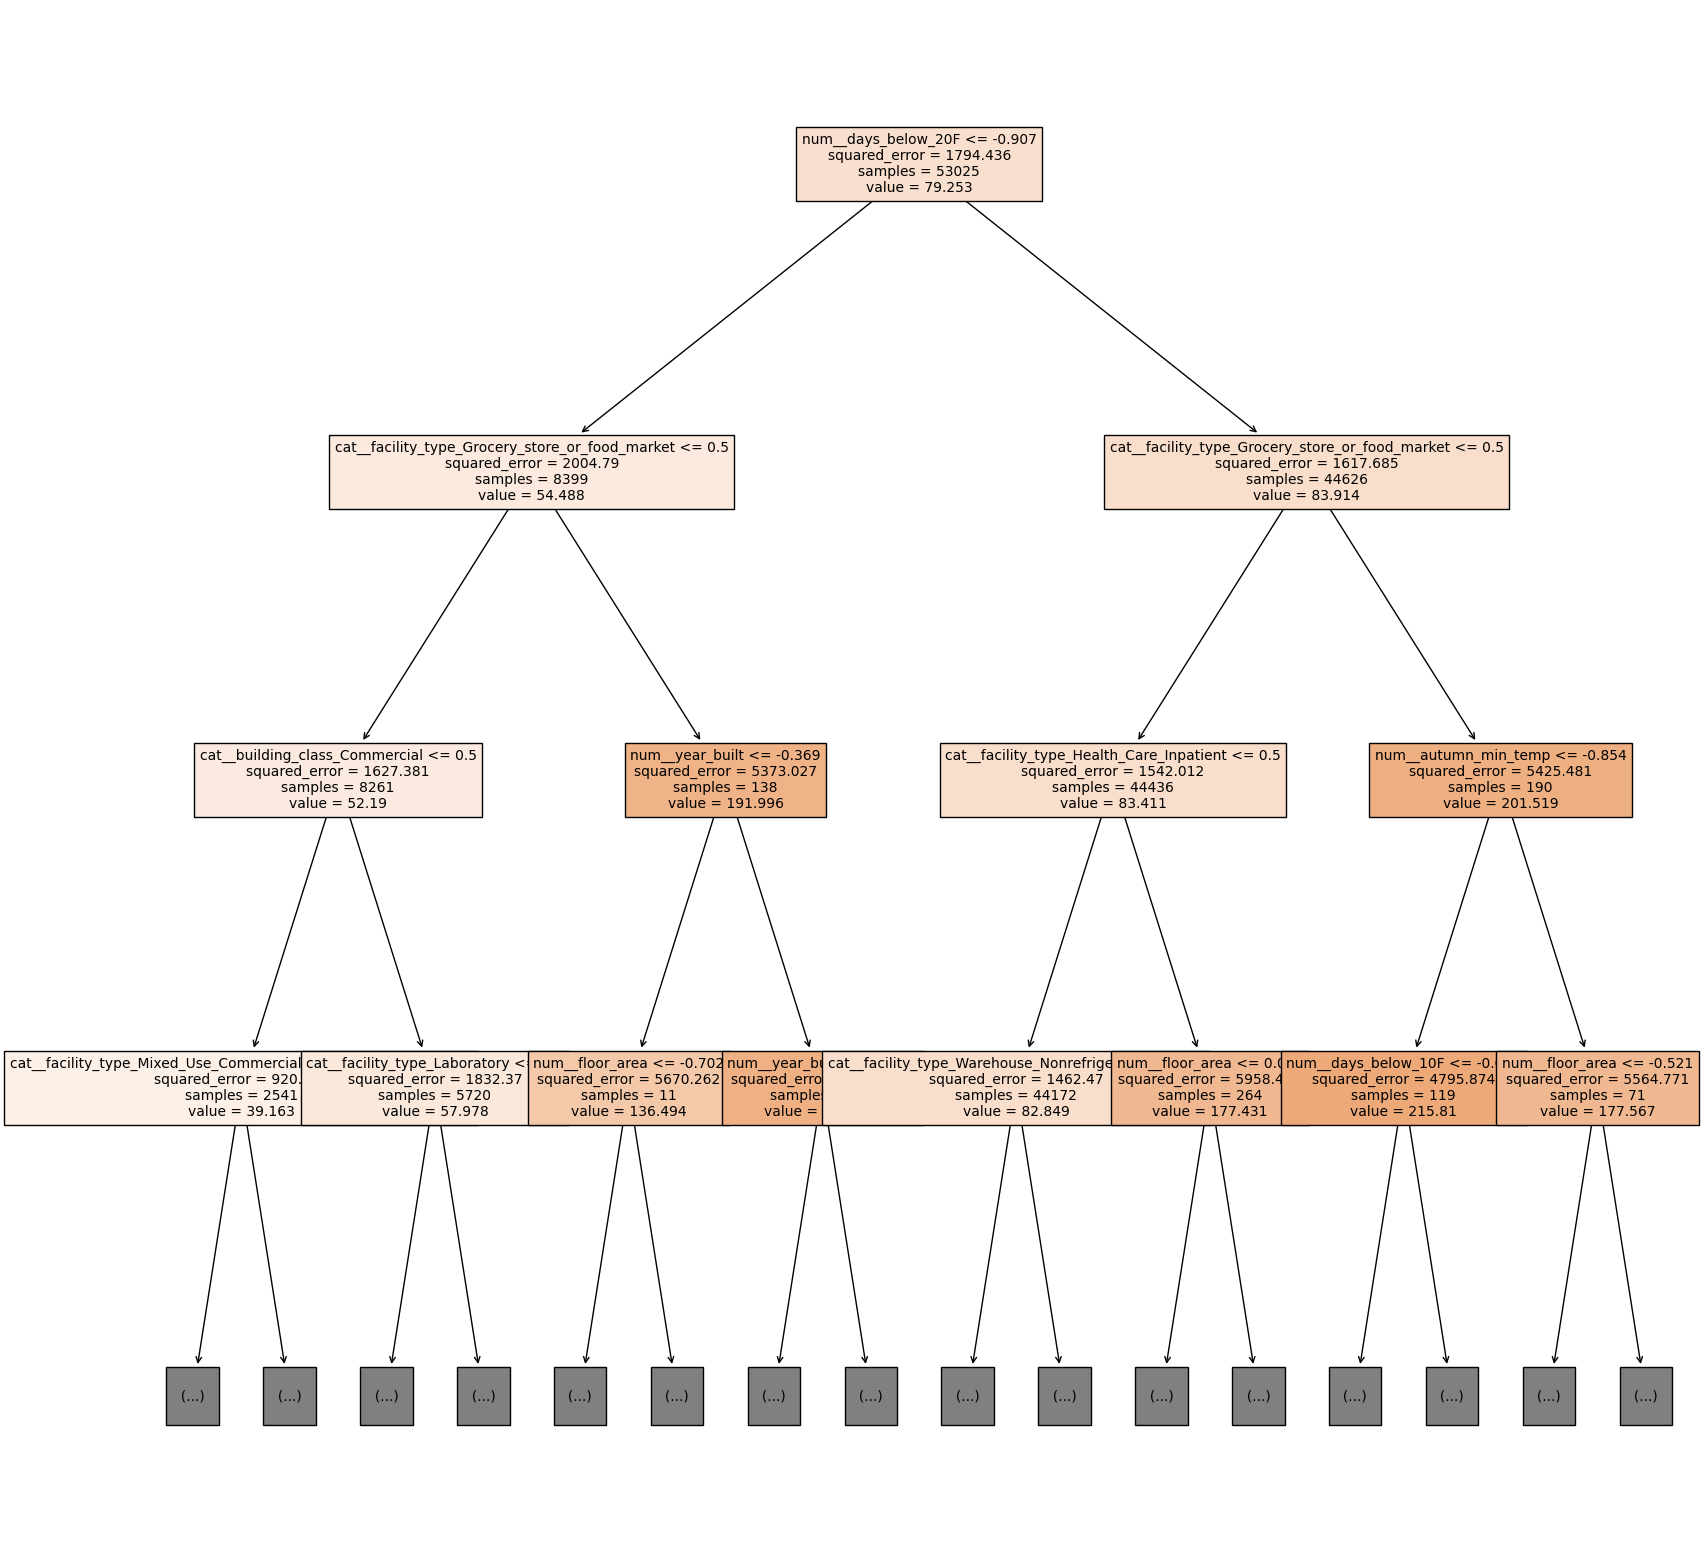

In [ ]:
model = DecisionTreeRegressor(splitter="best")

tree_pipe = Pipeline([('preprocessor', preprocessor),
                 ('model', model)])

tree_pipe.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out(X_train.columns)
plt.figure(figsize=(20, 20))
plot_tree(tree_pipe.named_steps['model'], filled=True, feature_names=feature_names,  max_depth=3, fontsize=10)
plt.show()

In the graph above we can analyse the way the decision tree regression model works with this data and params, it splits data and continuos to split it by making decisions.



---



Now we will run the models, since this is a regression problem we proceed to chose some main regression models to use:

> Linear Regression

> RidgeCV Regression

> Lasso Regression

> Random Forest Regression









We start with linear regression

In [ ]:
pipe = Pipeline([('preprocessor', preprocessor),
                 ('Linear Regression', LinearRegression())])

pipe.fit(X_train, y_train)
r2 =pipe.score(X_test, y_test)

In [ ]:
r2

0.4190891079802075

We get a r2 score of 0.41, which is not good enough, so we will proceed to try different models to see which of them and which parameters in them would be best to use.



---



We create a dict of the regression models that will be used, and the parameters to be compared. Here we include the imputer strategy for all the models and specific parameters for each model.

For the linear regression we just chose the imputer strategy, from ridgeCV the same but also the alphas, for Lasso the imputer strategy values and finally for random forest the imputer strategy and also max depth, min somple split and min samples leaf, parameters that are very important for preventing overfitting

In [ ]:
models = {
    'LinearRegression': (LinearRegression(), {'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant']}),
    'RidgeCV': (RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True), {'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant']}),
    'Lasso': (Lasso(), {'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant']}),
    'RandomForestRegressor': (RandomForestRegressor(), {'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant'],
                                                        'model__max_depth': [None, 10, 20],
                                                        'model__min_samples_split': [2, 5, 10],
                                                        'model__min_samples_leaf': [1, 2, 4]})
}

We analyse the models with randomizedSearchCv to have a quick analysis of the models' development

In [ ]:
for model_name, (model, param_dist) in models.items():
    random_search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score: {random_search.best_score_}")
    print("============================================")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'preprocessor__num__imputer__strategy': 'mean'}
Best score: -1986.8957472478469
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'preprocessor__num__imputer__strategy': 'mean'}
Best score: -1967.5839759491569
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'preprocessor__num__imputer__strategy': 'mean'}
Best score: -1971.0339231914872
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'preprocessor__num__imputer__strategy': 'mean', 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best score: -1323.9754933298461


We observe that it concludes that the best strategy to use in impute would be the mean values for all the models. We also observe that the best score is given by the Random Forest Regressor model(which is the last one)



---




Looking at the results messages it is recommended to use gridSearchCV, thereby we repeat this process with gridsearch

In [ ]:
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")
    print('-'*36)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for LinearRegression: {'preprocessor__num__imputer__strategy': 'constant'}
Best score for LinearRegression: -1990.5550787388675
------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for RidgeCV: {'preprocessor__num__imputer__strategy': 'constant'}
Best score for RidgeCV: -1982.4725175921817
------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Lasso: {'preprocessor__num__imputer__strategy': 'constant'}
Best score for Lasso: -1978.9119653024045
------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for RandomForestRegressor: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'preprocessor__num__imputer__strategy': 'mean'}
Best score for RandomForestRegressor: -1315.8649102722727
-------------------

From the grid searchCV analysis we can conclude the best model is the Random forest regressor model, with parameters as follows:



> Imputer: 'mean'

> a max_depth of 20

> min_samples_leafs of 2

> and min_sample_split of 10







From both results we can draw as a final conclusion that the best model to use in this particular case is the Random forest regressor model with the number_features imputer set with the mean of the values.

In [ ]:
pipe = Pipeline([('preprocessor', preprocessor),
                 ('RandomForestRegressor', RandomForestRegressor())])

pipe.fit(X_train, y_train)  # apply scaling on training data


r2 =pipe.score(X_test, y_test)
r2

0.5650844276744229